## 1. Loading the raw DataSUS file

### This block loads the original nationwide SRAG (INFLUD21) file from the Brazilian OpenDataSUS repository into a pandas DataFrame.

base_path and file_name explicitly identify the local path and filename of the 2021 SRAG dataset.


In [1]:
import os

path = r"C:\Users\graca\OneDrive\Área de Trabalho\datasus-datasets"  # R (raw string) 

print(os.listdir(path))  # to list .csv


['.Rhistory', 'desktop.ini', 'floridaxls.xlsx', 'INFLUD20-01-05-2023.csv', 'INFLUD20-01-05-2023.zip', 'INFLUD21-01-05-2023.csv', 'INFLUD21-01-05-2023.zip', 'INFLUD22-03-04-2023 (2).zip', 'INFLUD22-03-04-2023.csv', 'INFLUD22-03-04-2023.zip', 'INFLUD23-14-10-2024.csv', 'INFLUD23-14-10-2024.zip', 'INFLUD24-09-09-2024.csv', 'INFLUD24-14-10-2024.csv', 'INFLUD24-14-10-2024.zip', 'los_outputs']


In [2]:
import pandas as pd

base_path = r"C:\Users\graca\OneDrive\Área de Trabalho\datasus-datasets"
file_name = "INFLUD21-01-05-2023.csv"

full_path = fr"{base_path}\{file_name}"

df = pd.read_csv(full_path,
                 sep=";",          # cambiando para ","
                 encoding="latin1",
                 low_memory=False)

df.head()


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,DOSE_2_COV,DOSE_REF,FAB_COV_1,FAB_COV_2,FAB_COVREF,LOTE_REF,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV
0,06/01/2021,1,06/01/2021,1,BA,NUCLEO REGIONAL DE SAUDE NORDESTE,1382.0,ALAGOINHAS,290070,HOSPITAL REGIONAL DANTAS BIAO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08/01/2021,1,03/01/2021,1,BA,NUCLEO REGIONAL DE SAUDE SUL,1385.0,ITABUNA,291480,HOSPITAL CALIXTO MIDLEJ FILHO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09/01/2021,1,07/01/2021,1,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690,COMPLEXO HOSPITALAR DO TRABALHADOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/01/2021,1,05/01/2021,1,PR,17RS LONDRINA,1371.0,LONDRINA,411370,HCL HOSPITAL DO CANCER DE LONDRINA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/01/2021,2,04/01/2021,1,RS,007 CRS,1596.0,DOM PEDRITO,430660,HOSPITAL SAO LUIZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Defining the adult COVID-19 ICU cohort (mortality sample)

### This section reconstructs the exact cohort used in the V12 mortality models, using only information available at admission:

Adults only

NU_IDADE_N ≥ 18 keeps only adult patients, aligning the cohort with the age range used in the prediction models.

Confirmed COVID-19

CLASSI_FIN == 5 selects cases with final etiological classification compatible with confirmed COVID-19, ensuring that all patients in the cohort have virologically confirmed infection.

ICU admissions

UTI == 1 indicates at least one recorded ICU stay during hospitalization.

This subset (with_icu) is the base cohort for mortality prediction, representing all adult, confirmed COVID-19 ICU inpatients.

Hospital admission flag

HOSPITAL == 1 further restricts the sample to patients with the hospital admission flag set, which was used in the original V12 analysis (with_hosp).

For mortality analyses, the key ICU cohort is with_icu (n = 392,572), while with_hosp is relevant for flowchart accounting and LOS-ICU derivation.

In [3]:
import pandas as pd

# ===== PATH TO YOUR DATASET =====
base_path = r"C:\Users\graca\OneDrive\Área de Trabalho\datasus-datasets"
file_name = "INFLUD21-01-05-2023.csv"
full_path = fr"{base_path}\{file_name}"

# ===== LOAD THE RAW DATA =====
df = pd.read_csv(full_path,
                 sep=";",          # If all data appears in one column, change to ","
                 encoding="latin1",
                 low_memory=False)

print("File successfully loaded.")
print("Total raw records:", df.shape[0])

# ===============================================================
#   OFFICIAL FILTERS FOR THE V12 MORTALITY COHORT (ICU COVID)
# ===============================================================

# 1) Adults only (>= 18 years old)
df_adults = df[df['NU_IDADE_N'] >= 18]

# 2) Confirmed COVID-19 (CLASSI_FIN = 5)
df_covid = df_adults[df_adults['CLASSI_FIN'] == 5]

# 3) ICU admissions only (UTI = 1)
df_icu = df_covid[df_covid['UTI'] == 1]

print("\nFinal adult confirmed COVID-19 ICU cohort size:", df_icu.shape[0])

# ===============================================================
#   EVOLUCAO OUTCOME DISTRIBUTION (ALL CATEGORIES)
#   1 = Cura/Alta
#   2 = Óbito por SRAG/COVID
#   3 = Óbito por outras causas
#   9 = Ignorado
# ===============================================================

ev_mapping = {
    1: "1 - Cure/Discharge",
    2: "2 - Death (COVID-19/SRAG)",
    3: "3 - Death (other causes)",
    9: "9 - Unknown"
}

ev_counts = df_icu['EVOLUCAO'].value_counts().sort_index()
ev_props  = (df_icu['EVOLUCAO'].value_counts(normalize=True) * 100).round(2).sort_index()

print("\n===== EVOLUCAO — FULL OUTCOME DISTRIBUTION =====")
print("Counts:")
print(ev_counts.rename(index=ev_mapping))

print("\nProportions (%):")
print(ev_props.rename(index=ev_mapping))


# ===============================================================
#   EVOLUCAO ONLY (1 = Cure/Discharge, 2 = Death)
# ===============================================================

mask12 = df_icu['EVOLUCAO'].isin([1, 2])
ev12_counts = df_icu.loc[mask12, 'EVOLUCAO'].value_counts().sort_index()
ev12_props  = (df_icu.loc[mask12, 'EVOLUCAO'].value_counts(normalize=True) * 100).round(2).sort_index()

print("\n===== EVOLUCAO — BINARY OUTCOME (1 = Cure/Discharge, 2 = Death) =====")
print("Counts:")
print(ev12_counts.rename(index=ev_mapping))

print("\nProportions (%):")
print(ev12_props.rename(index=ev_mapping))


File successfully loaded.
Total raw records: 1731290

Final adult confirmed COVID-19 ICU cohort size: 392572

===== EVOLUCAO — FULL OUTCOME DISTRIBUTION =====
Counts:
EVOLUCAO
1 - Cure/Discharge           156376
2 - Death (COVID-19/SRAG)    217723
3 - Death (other causes)       1388
9 - Unknown                    5088
Name: count, dtype: int64

Proportions (%):
EVOLUCAO
1 - Cure/Discharge           41.09
2 - Death (COVID-19/SRAG)    57.21
3 - Death (other causes)      0.36
9 - Unknown                   1.34
Name: proportion, dtype: float64

===== EVOLUCAO — BINARY OUTCOME (1 = Cure/Discharge, 2 = Death) =====
Counts:
EVOLUCAO
1 - Cure/Discharge           156376
2 - Death (COVID-19/SRAG)    217723
Name: count, dtype: int64

Proportions (%):
EVOLUCAO
1 - Cure/Discharge           41.8
2 - Death (COVID-19/SRAG)    58.2
Name: proportion, dtype: float64


In [4]:
total_icu = df_icu.shape[0]
valid_evolucao = df_icu['EVOLUCAO'].notna().sum()

missing_evolucao = total_icu - valid_evolucao

print("Total ICU =", total_icu)
print("Valid EVOLUCAO =", valid_evolucao)
print("Missing EVOLUCAO =", missing_evolucao)


Total ICU = 392572
Valid EVOLUCAO = 380575
Missing EVOLUCAO = 11997


In [5]:
import pandas as pd

# Rebuild cohort exactly
base_path = r"C:\Users\graca\OneDrive\Área de Trabalho\datasus-datasets"
file_name = "INFLUD21-01-05-2023.csv"
full_path = fr"{base_path}\{file_name}"

df = pd.read_csv(full_path, sep=";", encoding="latin1", low_memory=False)

# Filters used in V12
df_adults = df[df['NU_IDADE_N'] >= 18]
df_covid = df_adults[df_adults['CLASSI_FIN'] == 5]
df_icu = df_covid[df_covid['UTI'] == 1]

total_icu = df_icu.shape[0]

print("Total ICU:", total_icu)

# EVOLUCAO counts including missing
valid_mask = df_icu['EVOLUCAO'].notna()
df_valid = df_icu[valid_mask]

missing_outcome = total_icu - df_valid.shape[0]

print("\nValid EVOLUCAO:", df_valid.shape[0])
print("Missing EVOLUCAO:", missing_outcome)

# FULL DISTRIBUTION (1,2,3,9)
full_counts = df_valid['EVOLUCAO'].value_counts().sort_index()
full_props_valid = (df_valid['EVOLUCAO'].value_counts(normalize=True) * 100).round(2).sort_index()
full_props_total = (df_valid['EVOLUCAO'].value_counts() / total_icu * 100).round(2).sort_index()

print("\n===== FULL EVOLUCAO DISTRIBUTION =====")
print("Counts (valid only):")
print(full_counts)

print("\nProportions (% of valid outcomes):")
print(full_props_valid)

print("\nProportions (% of total ICU cohort):")
print(full_props_total)

# BINARY (1 death / 2 discharge)
mask12 = df_valid['EVOLUCAO'].isin([1,2])
df_binary = df_valid[mask12]

bin_counts = df_binary['EVOLUCAO'].value_counts().sort_index()
bin_props_valid = (df_binary['EVOLUCAO'].value_counts(normalize=True) * 100).round(2).sort_index()
bin_props_total = (df_binary['EVOLUCAO'].value_counts() / total_icu * 100).round(2).sort_index()

print("\n===== BINARY OUTCOME (1 = DEATH, 2 = DISCHARGE) =====")
print("Counts:")
print(bin_counts)

print("\nProportions (% of valid outcomes 1/2 only):")
print(bin_props_valid)

print("\nProportions (% of total ICU cohort):")
print(bin_props_total)


Total ICU: 392572

Valid EVOLUCAO: 380575
Missing EVOLUCAO: 11997

===== FULL EVOLUCAO DISTRIBUTION =====
Counts (valid only):
EVOLUCAO
1.0    156376
2.0    217723
3.0      1388
9.0      5088
Name: count, dtype: int64

Proportions (% of valid outcomes):
EVOLUCAO
1.0    41.09
2.0    57.21
3.0     0.36
9.0     1.34
Name: proportion, dtype: float64

Proportions (% of total ICU cohort):
EVOLUCAO
1.0    39.83
2.0    55.46
3.0     0.35
9.0     1.30
Name: count, dtype: float64

===== BINARY OUTCOME (1 = DEATH, 2 = DISCHARGE) =====
Counts:
EVOLUCAO
1.0    156376
2.0    217723
Name: count, dtype: int64

Proportions (% of valid outcomes 1/2 only):
EVOLUCAO
1.0    41.8
2.0    58.2
Name: proportion, dtype: float64

Proportions (% of total ICU cohort):
EVOLUCAO
1.0    39.83
2.0    55.46
Name: count, dtype: float64


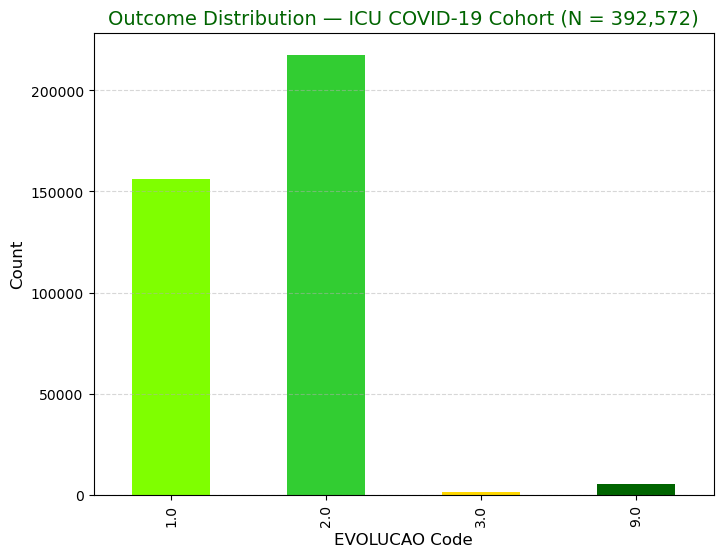

In [6]:
import matplotlib.pyplot as plt

colors = ["#7FFF00", "#32CD32", "#FFD700", "#006400"]  # fluor green / mint / gold / flag green

counts = df_icu['EVOLUCAO'].value_counts().sort_index()

plt.figure(figsize=(8,6))
counts.plot(kind='bar', color=colors)
plt.title("Outcome Distribution — ICU COVID-19 Cohort (N = 392,572)", fontsize=14, color="#006400")
plt.xlabel("EVOLUCAO Code", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


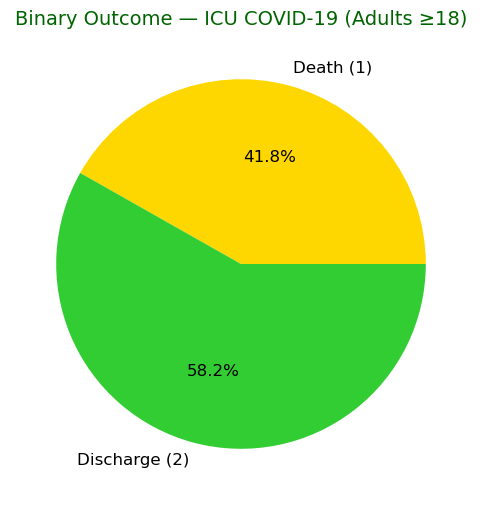

In [7]:
binary_counts = df_icu[df_icu['EVOLUCAO'].isin([1,2])]['EVOLUCAO'].value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(binary_counts,
        labels=["Death (1)", "Discharge (2)"],
        autopct='%1.1f%%',
        colors=["#FFD700", "#32CD32"],
        textprops={'fontsize': 12})

plt.title("Binary Outcome — ICU COVID-19 (Adults ≥18)", fontsize=14, color="#006400")
plt.show()


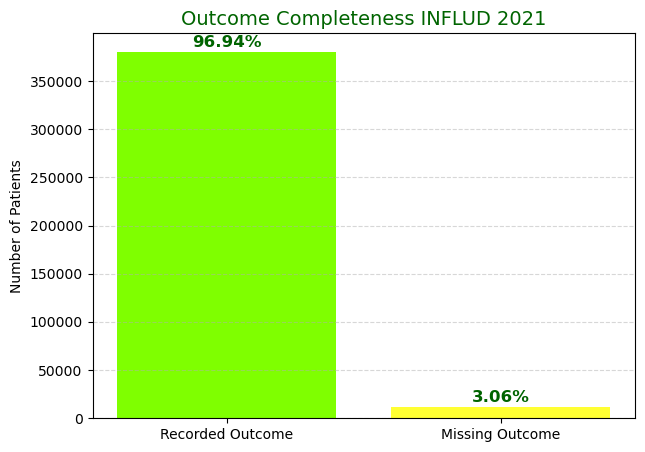

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Values
values = [df_valid.shape[0], missing_outcome]
labels = ["Recorded Outcome", "Missing Outcome"]
colors = ["#7FFF00", "#FFFF33"]  # fluor green + neon yellow

# Calculate percentages
total = sum(values)
percentages = [(v / total) * 100 for v in values]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors)

# Title and labels
plt.title("Outcome Completeness INFLUD 2021", fontsize=14, color="#006400")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add percentage labels above bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + total * 0.005,      # slight offset
             f"{pct:.2f}%",
             ha='center', va='bottom',
             fontsize=12, color="#006400", fontweight='bold')

plt.show()


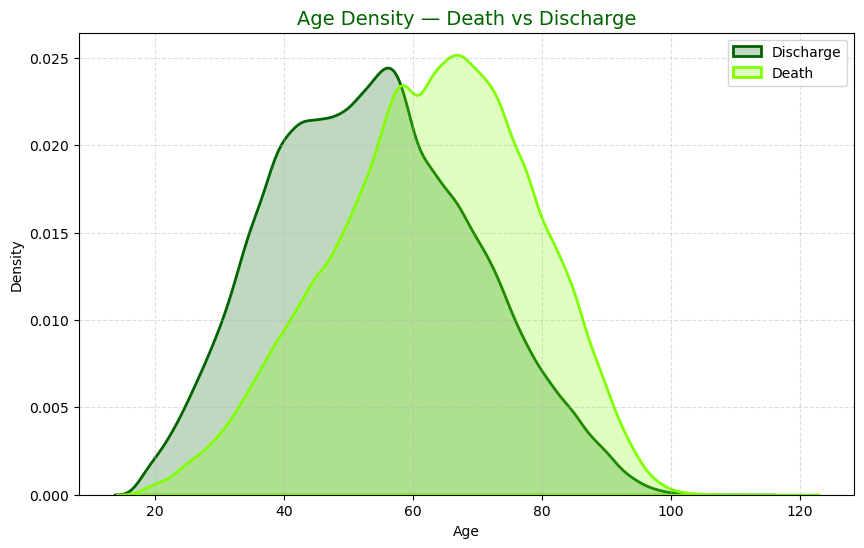

In [9]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(df_icu[df_icu['EVOLUCAO']==1]['NU_IDADE_N'], fill=True, linewidth=2,
            color="#006400", label="Discharge")
sns.kdeplot(df_icu[df_icu['EVOLUCAO']==2]['NU_IDADE_N'], fill=True, linewidth=2,
            color="#7FFF00", label="Death")

plt.title("Age Density — Death vs Discharge", fontsize=14, color="#006400")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()


C:\Users\graca\AppData\Local\Temp\ipykernel_28340\371940594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icu['age_group'] = pd.cut(df_icu['NU_IDADE_N'],


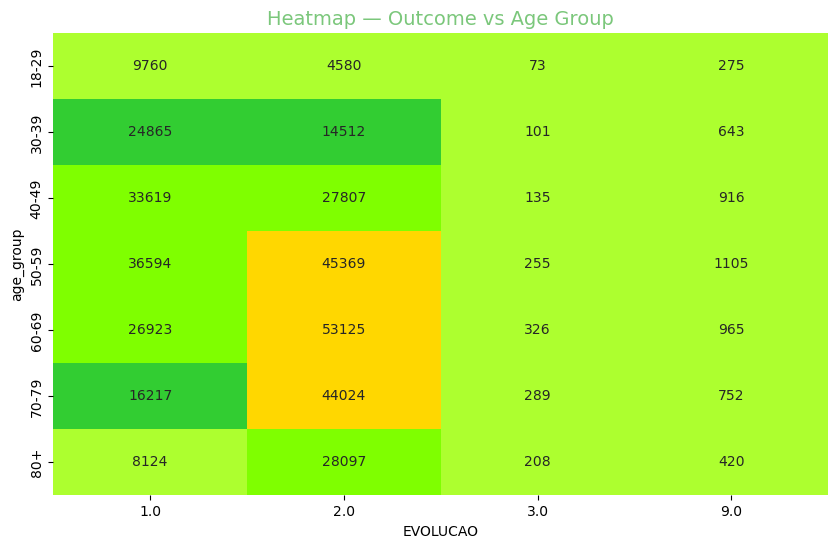

In [10]:
import numpy as np

df_icu['age_group'] = pd.cut(df_icu['NU_IDADE_N'],
                             bins=[18,30,40,50,60,70,80,100],
                             labels=["18-29","30-39","40-49","50-59","60-69","70-79","80+"])

pivot = pd.crosstab(df_icu['age_group'], df_icu['EVOLUCAO'])

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='d',
            cmap=["#ADFF2F","#32CD32","#7FFF00","#FFD700"],
            cbar=False)

plt.title("Heatmap — Outcome vs Age Group", fontsize=14, color="#7BC77B")
plt.show()


## Flowchart

In [11]:
#flowchart TD

#A[SRAG 2021 records\nN = 1,731,290] --> B[Adults ≥ 18 years\nN = 1,583,476\n(91.5% of all records)]

#B --> C[Confirmed COVID-19\n(CLASSI_FIN = 5)\nN = 1,192,530\n(75.3% of adults)]

#C --> D[ICU admissions\n(UTI = 1)\nN = 392,572\n(32.9% of confirmed;\n22.7% of all records)]

#D --> E[Valid outcome (EVOLUCAO recorded)\nN = 380,575\n(96.9% of ICU cohort)]

#D --> F[Missing outcome\nN = 11,997\n(3.1% of ICU cohort)\nExcluded from mortality modeling]
